# CS 536 : Decision Trees

#### Submitted by Nitin Reddy Karolla (nrk60)

### 1) For a given value of k, m, (number of features, number of data points), write a function to generate a training data set based on the above scheme.

In [3]:
# Importing the required packages for the assignment

import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

Following function generates the data as mentioned in question. Function expect m and k where m is the number of samples and k is the number of features. The data is generated based on the scheme mentioned in the question.

In [4]:
def data_generator(m,k):
    """
    Following function generates data required for the decision trees.
    Scheme : 
        X1 = 1 with probability 1/2, X1 = 0 with probability 1/2
        For i = 2, . . . , k, Xi = Xi−1 with probability 3/4, and 
        Xi = 1 − Xi−1 with probability 1/4
        Y = X1 if w2X2 + w3X3 + . . . + wkXk ≥ 1/2
            or 1 − X1 else
    Input : 
        m - Number of samples
        k - Number of features
    
    Output : 
        Dataframe with k+1 columns i.e. k features that represent X 
        and 1 the represents Y
    """
    X = [] 
    for j in range(m):
        y = []
        a = np.random.binomial(1, p=0.5, size= 1)[0]
        y.append(a)
        for i in range(k-1):
            x = np.random.binomial(1, p=0.75, size= 1)[0]
            if x == 1:
                y.append(a)
            else:
                y.append(1-a)
                a = 1-a
        X.append(y)
        
    #Generating the Weights
    j = 0.9*0.9
    s = j * (1 - (0.9 ** (k-1)))/ (1- 0.9)
    w = [0]
    for i in range(k-1):
        w_i = 0.9**(i+2)/ s
        w.append(w_i)
    
    #Generating the Y
    Y = []
    for i in range(m):
        y_i = [a*b for a,b in zip(X[i],w)]
        if sum(y_i) >= 0.5:
            Y.append(X[i][0])
        else:
            Y.append(1-X[i][0])
    
    #Generate column names
    colnames = [ 'X'+ str(i)  for i in range(1,k+1)]
    
    df = pd.DataFrame(data= X, columns= colnames)
    df['Y'] = pd.Series(data = Y)
    return(df)

### 2) Given a data set, write a function to fit a decision tree to that data based on splitting the variables by maximizing the information gain. Additionally, return the training error of this tree on the data set, err_train(ˆf). It may be useful to have a function that takes a data set and a variable, and returns the data set partitioned based on the values of that variable.


Let us create data structure called Node which will be holding on information like Data, Rule and the Children at that node in a decision tree.

In [5]:
class Node():
    """
    Node is a data structure which will be used for decision trees.
    
    Input :
        data = training data post split is stored
        rule = feature on which the split led to this node and the 
        value of the feature
        child = nodes of children of all this node are present 
        after the split
    """
    def __init__(self,
                 data = None,
                 rule = None,
                 child = None
                ):
        self.data = data
        self.rule = rule
        self.child = child

In [6]:
class Decision_Tree_ID3():
    """
    Decision Tree ID3 is trained on data with a target variable. It 
    is built on split variable which is indentified using the logic 
    of information gain 
    """
    def __init__(self, root = None):
        self.root = root
        
        
    def entropy(self, data, variable):
        """
        Calcuates the entropy for the given data and target variable
        """
        entropy_value = sum([(-data[variable].value_counts()[i]/ 
                              data[variable].count()) * np.log2((
            data[variable].value_counts()[i]/ 
            data[variable].count()) + 0.00000001) 
                             for i in data[variable].unique()])
        return entropy_value
    
    
    def information_gain(self, data, variable, target):
        """
        Calculates the information gain for the given variable and data
        """
        infomation_content = sum([data[variable].value_counts()[i]/
                                  data[variable].count()
                                  * self.entropy(data[data[variable]== i], 
                                                 target) 
                                  for i in data[variable].unique()])
        info_gain = self.entropy(data, target) - infomation_content
        return(info_gain)
    
    
    def split_variable_identification(self, data, target):
        """
        Identifies the split variable based on data and target
        """
        #loop through all features and calculate information gain for each feature
        variable_ig_required = list(data.columns)
        variable_ig_required.remove('Y')
        ig_values = [(i, self.information_gain(data,i,'Y')) 
                     for i in variable_ig_required]
        if len(ig_values) != 0:
            split_variable = max(ig_values, key = lambda item : item[1])
        else:
            split_variable = (0,0)
        return(split_variable)
    

    def split_data(self, data, split_variable): 
        """
        Splits the data after identifying the split variable, assigns 
        data and rule to the node.
        """
        splitted_data = [Node(data = (data[data[split_variable] == i].
                                      drop(split_variable,1)),
                              rule = (split_variable,i)) 
                         for i in data[split_variable].unique()]
        return(splitted_data)
    
    
    def fit(self, data, target):
        """
        Fit is used to fit decision trees on the data for a given target variable
        """
        if type(data) != Node:
            data = Node(data = data)
            self.root = data

        if self.split_variable_identification(data.data, target)[1] == 0:
            return

        split_variable = self.split_variable_identification(data.data, target)[0]
        data.child = self.split_data(data.data, split_variable)

        for i in data.child:
            if i.data['Y'].nunique() != 1: 
                self.fit(i, target)
            
    
    def get_rules(self, model = None ,ruleList = []):
        """
        Returns the rules for each leaf and the major class in the leaf
        """
        if model == None:
            model = self.root
        ruleList.append(model.rule)
        if model.child == None:
            ruleList.append(model.data['Y'].mode()[0])
            return print(ruleList[1:])
        for i in model.child:
            self.get_rules(i,ruleList.copy())
    

    def predict_row(self, model, row):
        """
        This function returns the prediction for the a single sample of 
        data using the fitted data
        """
        if model.child == None:
            return(model.data['Y'].mode()[0])

        variable = model.child[0].rule[0]
        row_value = row[variable]
        for i in model.child:
            if i.rule[1] == row_value:
                return self.predict_row(i, row)
            
    def predict(self, test):
        """
        Predict funtion will take an input data and return the prediction
        based on the fitted decision tree
        """
        predicted_y = []
        for i in test.iterrows():
            x = i[1]
            y = self.predict_row(self.root, x)
            predicted_y.append(y)
        return pd.Series(predicted_y)
    
    def training_error(self):
        """
        Returns the training error of the  fitted decision tree
        """
        predict_train = self.predict(data)
        return (1 -sum(data['Y'] == predict_train)/ len(data))
            

### 3) For k = 4 and m = 30, generate data and fit a decision tree to it. Does the ordering of the variables in the decision tree make sense, based on the function that defines Y ? Why or why not? Draw the tree.

In [5]:
#Generating the data for m = 30 , k = 4
data = data_generator(m =30, k =4)

In [6]:
model = Decision_Tree_ID3()

In [7]:
model.fit(data, "Y")

In [8]:
model.get_rules()

[('X2', 0), ('X4', 1), ('X3', 1), 0]
[('X2', 0), ('X4', 1), ('X3', 0), 1]
[('X2', 0), ('X4', 0), 1]
[('X2', 1), ('X1', 1), ('X3', 1), 1]
[('X2', 1), ('X1', 1), ('X3', 0), ('X4', 0), 0]
[('X2', 1), ('X1', 1), ('X3', 0), ('X4', 1), 1]
[('X2', 1), ('X1', 0), 0]


Above is the decision tree, i.e. it gives the 'Y' value which is last element of each array based on the various values of features.
For Example , X4 =0, X1 =1, X3 = 1, X2=1 will have "Y" value has 1.

In [9]:
model.training_error()

0.0

As observed in various decision trees, 'X1' feature seems to play a major roles among the ordering in which the split variables is chosen, and it makes sense as X1 plays an important role in determing the value of Y. Also, X1 interaction with other variables plays important role and mostly the initital features as weight being multiplied is higher and increases the chance of sum being > 1/2 which inturn plays a role in determining the Y.

Also, we notice that Y is deterministic with respect to the values of X.

### 4) Write a function that takes a decision tree and estimates its typical error on this data err( ˆf); i.e., generate a lot of data according to the above scheme, and find the average error rate of this tree over that data

For the same decision tree built above, lets find the average error rate of this tree.

In [13]:
def typical_error(model, test_data_size, simulations = 50):
    """
    Generate error for similations for a generated test data and 
    given decision tree.
    """
    k = model.root.data.shape[1]-1
    error = []
    for i in range(simulations):
        test_data = data_generator(test_data_size, k)
        predicted_y = model.predict(test_data)
        error_current = 1 -(sum(test_data['Y'] == predicted_y)/ len(test_data))
        error.append(error_current)
    return error

In [11]:
err_f = typical_error(model, test_data_size=30)

In [12]:
print("Average typical error of the decision tree is ", sum(err_f)/len(err_f))

Average typical error of the decision tree is  0.14333333333333328


### 5) For k = 10, estimate the value of |errtrain(ˆf) − err( ˆf)| for a given m by repeatedly generating data sets, fitting trees to those data sets, and estimating the true and training error. Do this for multiple m, and graph this difference as a function of m. What can you say about the marginal value of additional training data?

In [13]:
#Let us define the values required to understand the marginal value of additional training data
k = 10

#Defining the repetitions values for generating m samples of training data
start = 50
end = 2500
step = 25

In [14]:
err_abs = []
m = []
for i in tqdm(range(start,end,step)):
    data = data_generator(i, k = 10)
    dt = Decision_Tree_ID3()
    dt.fit(data, 'Y')
    err_f = typical_error(dt, 100)
    err_final = sum(err_f)/len(err_f)
    err_train = dt.training_error()
    m.append(i)
    #print( err_final, err_train)
    err_abs.append(abs(err_final-err_train))

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [12:13<00:00, 10.12s/it]


Text(0.5,1,'Marginal error vs the training size (m)')

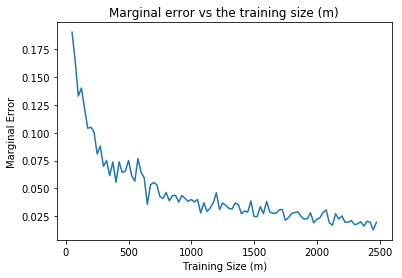

In [15]:
sns.lineplot(m,err_abs)
plt.xlabel("Training Size (m)")
plt.ylabel("Marginal Error")
plt.title("Marginal error vs the training size (m)")

As, we can see the adding of additional data to training leads to decrease in the error of decision tree. However, after a point increase in training data does not really lead to greater decrease in marginal error.
For a feature = k, there are 2^k possible X and Y events. Once the decision tree is trained on that data, error reduces to almost nil as generating a new test data will be a combination of original train data.

### 6) Design an alternative metric for splitting the data, not based on information content / information gain. Repeat the computation from (5) above for your metric, and compare the performance of your trees vs the ID3 trees

Now I build the same decision tree, but using the gini-impurity as the metric to identify the split variable.

In [1]:
class Decision_Tree_Gini_Impurity():
    """
    Decision Tree Gini Impurity is trained on data with a target variable. 
    It is built on split variable which is indentified using the 
    logic of Gini Impurity.
    """
    def __init__(self, root = None):
        self.root = root
        
        
    def gini_index(self, data, variable):
        """
        Calcuates the gini index for the given data and target variable
        """
        # Calculate the entropy of target variable
        gini_index = 1 - sum([pow(data[variable].value_counts()[i]/ 
                                  data[variable].count(),2) 
                              for i in data[variable].unique()])
        return gini_index
    
    
    def gini_gain(self, data, variable, target):
        """
        Calculates the gini impurity for the given variable and data
        """
        gini_index_varaible = sum([data[variable].value_counts()[i]/
                                   data[variable].count() * 
                                   self.gini_index(data[data[variable]== i], 
                                                   target) for i in 
                                   data[variable].unique()])
        gini_gain_value = gini_index_varaible
        return(gini_gain_value)
    
    
    def split_variable_identification(self, data, target):
        """
        Identifies the split variable based on data and target
        """
        #loop through all features and calculate gini gain for each feature
        variable_ig_required = list(data.columns)
        variable_ig_required.remove('Y')
        ig_values = [(i, self.gini_gain(data,i,'Y')) for i in 
                     variable_ig_required]
        if len(ig_values) != 0:
            split_variable = min(ig_values, key = lambda item : item[1])
        else:
            split_variable = (0,0)
        return(split_variable)
    

    def split_data(self, data, split_variable): 
        """
        Splits the data after identifying the split variable, assigns 
        data and rule to the node.
        """
        splitted_data = [Node(data = (data[data[split_variable] == i].
                                      drop(split_variable,1)), 
                              rule = (split_variable,i)) for i in 
                         data[split_variable].unique()]
        return(splitted_data)
    
    
    def fit(self, data, target):
        """
        Fit is used to fit decision trees on the data for a given target variable
        """
        if type(data) != Node:
            data = Node(data = data)
            self.root = data

        #if self.split_variable_identification(data.data, target)[1] == 0:
        #    return

        split_variable = self.split_variable_identification(data.data,
                                                            target)[0]
        data.child = self.split_data(data.data, split_variable)

        for i in data.child:
            if i.data['Y'].nunique() != 1: 
                self.fit(i, target)
            
    
    def get_rules(self, model = None ,ruleList = []):
        """
        Returns the rules for each leaf and the major class in the leaf
        """
        if model == None:
            model = self.root
        ruleList.append(model.rule)

        if model.child == None:
            ruleList.append(model.data['Y'].mode()[0])
            return print(ruleList[1:])

        for i in model.child:
            self.get_rules(i,ruleList.copy())
    

    def predict_row(self, model, row):
        """
        This function returns the prediction for the a single sample of 
        data using the fitted data
        """
        if model.child == None:
            return(model.data['Y'].mode()[0])

        variable = model.child[0].rule[0]
        row_value = row[variable]
        for i in model.child:
            if i.rule[1] == row_value:
                return self.predict_row(i, row)
            
    def predict(self, test):
        """
        Predict funtion will take an input data and return the prediction 
        based on the fitted decision tree
        """
        predicted_y = []
        for i in test.iterrows():
            x = i[1]
            y = self.predict_row(self.root, x)
            predicted_y.append(y)
        return pd.Series(predicted_y)
    
    def training_error(self):
        """
        Returns the training error of the  fitted decision tree
        """
        predict_train = self.predict(data)
        return (1 -sum(data['Y'] == predict_train)/ len(data))
            

In [7]:
data = data_generator(30,4)
model = Decision_Tree_Gini_Impurity()

In [8]:
model.fit(data,'Y')

In [9]:
model.get_rules()

[('X1', 0), ('X3', 0), 1]
[('X1', 0), ('X3', 1), ('X4', 1), 0]
[('X1', 0), ('X3', 1), ('X4', 0), 1]
[('X1', 1), ('X3', 1), 1]
[('X1', 1), ('X3', 0), ('X2', 0), 0]
[('X1', 1), ('X3', 0), ('X2', 1), ('X4', 0), 0]
[('X1', 1), ('X3', 0), ('X2', 1), ('X4', 1), 1]


In [10]:
model.training_error()

0.0

In [11]:
#Let us define the values required to understand the marginal value of additional 
#training data
k = 10

#Defining the repetitions values for generating m samples of training data
start = 50
end = 2500
step = 25

In [14]:
err_abs2 = []
m2 = []
for i in tqdm(range(start,end,step)):
    data = data_generator(i, k = k)
    dt = Decision_Tree_Gini_Impurity()
    dt.fit(data, 'Y')
    err_f = typical_error(dt, 100)
    err_final = sum(err_f)/len(err_f)
    err_train = dt.training_error()
    m2.append(i)
    #print( err_final, err_train)
    err_abs2.append(abs(err_final-err_train))

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [05:34<00:00,  4.24s/it]


Text(0.5,1,'Marginal error vs the training size (m)')

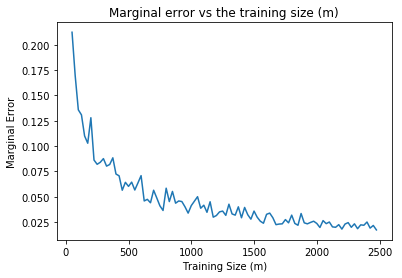

In [15]:
sns.lineplot(m2,err_abs2)
plt.xlabel("Training Size (m)")
plt.ylabel("Marginal Error")
plt.title("Marginal error vs the training size (m)")

We see a similar trend here as compared to the ID3 decision tree. Both of the methods of splitting seems to produce a close marginal error. On increasing the training data size, the marginal error reduces here same as in the case of ID3 decision tree.